In [5]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import pybedtools as pbt
import math
import pyranges as pr
import itertools
import functions as fn


In [6]:
wd = "/Genomics/kocherlab/bjarnold/Nmel"
bioreps = ['F1', 'F2', 'F3']

macs_peaks_files = [f"{wd}/MACS2/Nmel-{b}_peaks.narrowPeak" for b in bioreps]
# 1. chromosome
# 2. start
# 3. end
# 4. name
# 5. score
# 6. strand
# 7. signalValue - measurement of overall enrichment for the region
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - Point-source called for this peak; -based offset from chromStart

genrich_peaks_files = [f"{wd}/genrich_single/Nmel-{b}_peaks.narrowPeak" for b in bioreps]
# 1. chromosome
# 2. chromStart
# 3. chromEnd
# 4. name
# 5. score
# 6. strand
# 7. signalValue - total area under the curve (AUC)
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - summit position (0-based offset from chromStart)
genrich_multi_peak_file = f"{wd}/genrich_multi/Nmel_peaks.narrowPeak"

genrich_pileup_files = [f"{wd}/genrich_single/Nmel-{b}_pileups.txt" for b in bioreps]

chr1_test = True
qval_threshold = 1 # 1.3 corresponds to pvalue of 0.05, 1 corresponds to pvalue of 0.1
macs_folddiff_threshold = 2
genrich_area_threshold = 200
dist_thresh = 100 # distance b/t peak summits, used for overlapping results across methods or bioreps
print(macs_peaks_files)
print(genrich_peaks_files)
print(genrich_pileup_files)

['/Genomics/kocherlab/bjarnold/Nmel/MACS2/Nmel-F1_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/Nmel/MACS2/Nmel-F2_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/Nmel/MACS2/Nmel-F3_peaks.narrowPeak']
['/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F1_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F2_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F3_peaks.narrowPeak']
['/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F1_pileups.txt', '/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F2_pileups.txt', '/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F3_pileups.txt']


From the Genrich [github repo](https://github.com/jsh58/Genrich#controlbackground-pileup-calculation):
The background pileup value is calculated by dividing the total sequence information (sum of read/fragment/interval lengths) in the experimental sample by the calculated genome length. The net control pileup value at a particular genomic position is the maximum of the background pileup value and the pileup of the control sample at that position (if a control sample is specified). Note that control pileups are scaled to match the experimental, based on the total sequence information in each.

Because the control pileup never dips below the background pileup, MACS could be calculating a fold diff that looks very different from the Genrich pileup data, in which local depth pileup that MACS is using is actually quite low but Genrich is using the background pileup value. This is why the MACS fold diff is so high.

As a control, MACS2 [fits a poisson](https://hbctraining.github.io/Intro-to-ChIPseq/lessons/05_peak_calling_macs.html#:~:text=about%20computing%20it.-,Peak%20detection,-After%20MACS%20shifts) to the surrounding 1kb, 5kb, 10kb, and also has a background poisson rate from entire genome. The maximum of these is used as the background rate. 

There may also be a discrepancy between MACS and Genrich results due to the fact that Genrich used a MQ cutoff whereas MACS did not.

In [7]:
# pileup_dfs = [] # list of pileup dataframes
# for f in genrich_pileup_files:
#     df = pd.read_csv(f, sep="\t", header=1)
#     df.columns = ["Chromosome", "Start", "End", "experimental", "control", "-log(p)"]
#     # change experimental, control, and -log(p) columns to numeric
#     df[['Start', 'End', 'experimental', 'control', '-log(p)']] = df[['Start', 'End', 'experimental', 'control', '-log(p)']].apply(pd.to_numeric)
#     df['fold_diff'] = df['experimental']/df['control']
#     df['midpoint'] = (df['End'] - df['Start'])/2 + df['Start']
#     if chr1_test:
#         df = df[df['Chromosome'] == "NMEL_chr_1"]
#     pileup_dfs.append(df)
pileup_dfs = fn.load_genrich_pileup_files(genrich_pileup_files, chr1_test=chr1_test)

In [8]:
macs_dfs = [] # list of macs dataframes
genrich_dfs = [] # list of genrich dataframes

# def load_peak_caller_results(files):
#     df_list = []
#     for f in files:
#         df = pd.read_csv(f, sep="\t", header=None)
#         df.columns = ["Chromosome", "Start", "End", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"]
#         df = df.sort_values(by=["Chromosome", "Start"])
#         df["peak_coord"] = df["peak"] + df["Start"]
#         if chr1_test:
#             df = df[df['Chromosome'] == "NMEL_chr_1"]
#         df_list.append(df)
#     return df_list

macs_dfs = fn.load_peak_caller_results(macs_peaks_files, chr1_test)
genrich_dfs = fn.load_peak_caller_results(genrich_peaks_files, chr1_test)
genrich_multi_df = fn.load_peak_caller_results([genrich_multi_peak_file], chr1_test)[0]

# FILTER PEAK FILES BY SIGNIFICANCE, EFFECT SIZE
macs_dfs = fn.filter_by_sig_effect_size(macs_dfs, qval_threshold, macs_folddiff_threshold)
genrich_dfs = fn.filter_by_sig_effect_size(genrich_dfs, qval_threshold, genrich_area_threshold)

# print("MACS2 FILTERING")
# for i,m in enumerate(macs_dfs):
#     print("before filtering:", len(m))
#     macs_dfs[i] = m[(m['qValue'] > qval_threshold) & 
#                     (m['signalValue'] > macs_folddiff_threshold)]
#     print("after filtering:", len(macs_dfs[i]))

# print("GENRICH FILTERING")
# for i,g in enumerate(genrich_dfs):
#     print("before filtering:", len(g))
#     genrich_dfs[i] = g[(g['qValue'] > qval_threshold) & 
#                        (g['signalValue'] > genrich_area_threshold)]
#     print("after filtering:", len(genrich_dfs[i]))

print([len(df) for df in macs_dfs])



MACS2 FILTERING
before filtering: 5263
after filtering: 1884
before filtering: 5257
after filtering: 1744
before filtering: 5392
after filtering: 1920
GENRICH FILTERING
before filtering: 6400
after filtering: 2022
before filtering: 5819
after filtering: 1319
before filtering: 6352
after filtering: 1745
[1884, 1744, 1920]


In [ ]:
before filtering: 5263
after filtering: 1884
before filtering: 5257
after filtering: 1744
before filtering: 5392
after filtering: 1920
before filtering: 6400
after filtering: 2022
before filtering: 5819
after filtering: 1319
before filtering: 6352
after filtering: 1745
[1884, 1744, 1920]

peaks above q value: 93111
peaks below q value: 17139
peaks above q value: 91552
peaks below q value: 18645
peaks above q value: 93345
peaks below q value: 18938


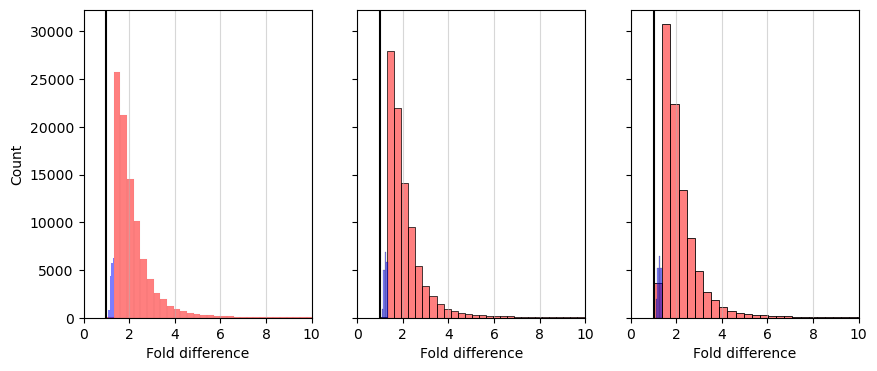

In [81]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
for i,m in enumerate(macs_dfs):
    a = m['signalValue'][m['qValue'] > 1.3]
    b = m['signalValue'][m['qValue'] <= 1.3]
    sns.histplot(a, color="red", alpha=0.5, stat='count', bins=1000, ax=axs[i])
    sns.histplot(b, color="blue", alpha=0.5, stat='count', bins=5, ax=axs[i])
    axs[i].set_xlim(0,10)
    axs[i].axvline(x=1, color="black")
    axs[i].set_xlabel("Fold difference")
    axs[i].grid(axis='x', alpha=0.5)
    print("peaks above q value:", len(a))
    print("peaks below q value:", len(b))

In [82]:
enhancer_density_chr1 = 4403/14215035
enhancer_density_gw = 17139/(300*10**6)
print(1/enhancer_density_chr1)
print(1/enhancer_density_gw)
print("max density of enhancers in human genome:", 1/((1*10**6)/(3*10**9)))

3228.488530547354
17503.93838613688
max density of enhancers in human genome: 3000.0


In [83]:
len(macs_dfs)

3

In [84]:
# Filter results according to significance and effect size, either fold diff for MACS or AUC for Genrich



MACS2 FILTERING
before filtering: 110250
after filtering: 40206
before filtering: 110197
after filtering: 37431
before filtering: 112283
after filtering: 42201
GENRICH FILTERING
before filtering: 132921
after filtering: 43306
before filtering: 121542
after filtering: 28833
before filtering: 134246
after filtering: 38184


In [85]:
# look at overlaps between methods within bioreps
macs_peaks_overlaps = []
genrich_peaks_overlaps = []
for macs_df,genrich_df in zip(macs_dfs, genrich_dfs):
    m = pr.PyRanges(chromosomes=macs_df.Chromosome,
                    starts=macs_df.peak_coord - dist_thresh,
                    ends=macs_df.peak_coord + dist_thresh)
    g = pr.PyRanges(chromosomes=genrich_df.Chromosome,
                    starts=genrich_df.peak_coord - dist_thresh,
                    ends=genrich_df.peak_coord + dist_thresh)
    macs_peaks_overlaps.append( (len(m), len(m.intersect(g))/len(m)) )
    genrich_peaks_overlaps.append( (len(g),len(g.intersect(m))/len(g)) )


for i,m in enumerate(macs_peaks_overlaps):
    print(f"MACS2: {m[0]} peaks, {m[1]*100:.2f}% overlap with Genrich peaks")
for i,m in enumerate(genrich_peaks_overlaps):
    print(f"Genrich: {m[0]} peaks, {m[1]*100:.2f}% overlap with MACS2 peaks")

MACS2: 40206 peaks, 85.76% overlap with Genrich peaks
MACS2: 37431 peaks, 69.29% overlap with Genrich peaks
MACS2: 42201 peaks, 79.99% overlap with Genrich peaks
Genrich: 43306 peaks, 79.62% overlap with MACS2 peaks
Genrich: 28833 peaks, 89.95% overlap with MACS2 peaks
Genrich: 38184 peaks, 88.40% overlap with MACS2 peaks


In [86]:
# look at overlaps within methods between bioreps

# get all pairwise combinations of biorep indices (i.e. (0,1), (0,2), (1,2)))
def get_summit_overlaps_within_method_across_reps(df_list, bioreps, dist_thresh):
    results = []
    biorep_combinations = list(itertools.combinations(range(len(bioreps)), 2))
    for rep in biorep_combinations:
        r1, r2 = rep
        pr1 = pr.PyRanges(chromosomes=df_list[r1].Chromosome,
                        starts=df_list[r1].peak_coord - dist_thresh,
                        ends=df_list[r1].peak_coord + dist_thresh)
        pr2 = pr.PyRanges(chromosomes=df_list[r2].Chromosome,
                            starts=df_list[r2].peak_coord - dist_thresh,
                            ends=df_list[r2].peak_coord + dist_thresh)
        o = pr1.intersect(pr2)
        results.append((len(pr1), len(pr2), len(o)))
    return(results)

def get_peak_overlaps_within_method_across_reps(df_list, bioreps):
    results = []
    biorep_combinations = list(itertools.combinations(range(len(bioreps)), 2))
    for rep in biorep_combinations:
        r1, r2 = rep
        pr1 = pr.PyRanges(chromosomes=df_list[r1].Chromosome,
                        starts=df_list[r1].Start,
                        ends=df_list[r1].End)
        pr2 = pr.PyRanges(chromosomes=df_list[r2].Chromosome,
                            starts=df_list[r2].Start,
                            ends=df_list[r2].End)
        cov1 = pr1.coverage(pr2, overlap_col="C", fraction_col="F")
        cov2 = pr1.coverage(pr2, overlap_col="C", fraction_col="F")
        print(cov1.head())
        print(cov2.head())
        # results.append((len(pr1), len(pr2), len(o)))
    return(results)

# macs_peaks_overlaps = get_summit_overlaps_within_method_across_reps(macs_dfs, bioreps, dist_thresh)
# genrich_peaks_overlaps = get_summit_overlaps_within_method_across_reps(genrich_dfs, bioreps, dist_thresh)

macs_peaks_overlaps = get_peak_overlaps_within_method_across_reps(macs_dfs, bioreps)
# genrich_peaks_overlaps = get_peak_overlaps_within_method_across_reps(genrich_dfs, bioreps, dist_thresh)

print(macs_peaks_overlaps)
print(genrich_peaks_overlaps)




+--------------+-----------+-----------+-----------+-------------+
| Chromosome   |     Start |       End |         C |           F |
| (category)   |   (int64) |   (int64) |   (int64) |   (float64) |
|--------------+-----------+-----------+-----------+-------------|
| NMEL_chr_1   |       464 |      1856 |         1 |    0.388649 |
| NMEL_chr_1   |      9111 |     10454 |         1 |    1        |
| NMEL_chr_1   |     26482 |     27230 |         1 |    0.466578 |
| NMEL_chr_1   |     35789 |     37123 |         1 |    1        |
| NMEL_chr_1   |     37568 |     39340 |         1 |    0.989278 |
| NMEL_chr_1   |     43501 |     45430 |         2 |    0.480041 |
| NMEL_chr_1   |     45964 |     47093 |         1 |    0.988485 |
| NMEL_chr_1   |     48342 |     49647 |         1 |    0.871264 |
+--------------+-----------+-----------+-----------+-------------+
Unstranded PyRanges object has 8 rows and 5 columns from 1 chromosomes.
For printing, the PyRanges was sorted on Chromosome.
+---

In [87]:
p1 = pr.PyRanges(chromosomes=genrich_dfs[0].Chromosome,
                starts=genrich_dfs[0].Start,
                ends=genrich_dfs[0].End)
p2 = pr.PyRanges(chromosomes=genrich_dfs[1].Chromosome,
                    starts=genrich_dfs[1].Start,
                    ends=genrich_dfs[1].End)
p3 = pr.PyRanges(chromosomes=genrich_dfs[2].Chromosome,
                    starts=genrich_dfs[2].Start,
                    ends=genrich_dfs[2].End)

In [88]:
p1.coverage(p2, overlap_col="C", fraction_col="F")

,Chromosome,Start,End,C,F
0,NMEL_chr_1,464,963,0,0.000000
1,NMEL_chr_1,9297,10150,1,0.985932
2,NMEL_chr_1,21190,21538,0,0.000000
3,NMEL_chr_1,26482,27367,0,0.000000
4,NMEL_chr_1,36753,37234,1,1.000000
...,...,...,...,...,...
43301,NMEL_unplaced_2947,29,1003,1,0.979466
43302,NMEL_unplaced_2952,243,941,0,0.000000
43303,NMEL_unplaced_2953,177,460,1,1.000000
43304,NMEL_unplaced_2954,15,784,1,0.807542


In [89]:
c = p1.coverage(p2, overlap_col="C", fraction_col="F")

In [91]:
c = c.df
print(len(c[(c['C']>=1) & (c['F']>0.5)]))
print(len(c))

11615
43306


In [ ]:
print(p1.head())
print(p2.head())
# print(p3.head())

+--------------+-----------+-----------+
| Chromosome   |     Start |       End |
| (category)   |   (int64) |   (int64) |
|--------------+-----------+-----------|
| NMEL_chr_1   |       464 |       963 |
| NMEL_chr_1   |      9297 |     10150 |
| NMEL_chr_1   |     26482 |     27367 |
| NMEL_chr_1   |     36753 |     37234 |
| NMEL_chr_1   |     38068 |     38751 |
| NMEL_chr_1   |     43631 |     44247 |
| NMEL_chr_1   |     44363 |     45266 |
| NMEL_chr_1   |     45933 |     47093 |
+--------------+-----------+-----------+
Unstranded PyRanges object has 8 rows and 3 columns from 1 chromosomes.
For printing, the PyRanges was sorted on Chromosome.
+--------------+-----------+-----------+
| Chromosome   |     Start |       End |
| (category)   |   (int64) |   (int64) |
|--------------+-----------+-----------|
| NMEL_chr_1   |      6189 |      6827 |
| NMEL_chr_1   |      9309 |     10843 |
| NMEL_chr_1   |     17027 |     17871 |
| NMEL_chr_1   |     25674 |     26084 |
| NMEL_chr_1  

0 1
['F0', 'F1', 'comp']
0 2
['F0', 'F2', 'comp']
1 2
['F1', 'F2', 'comp']


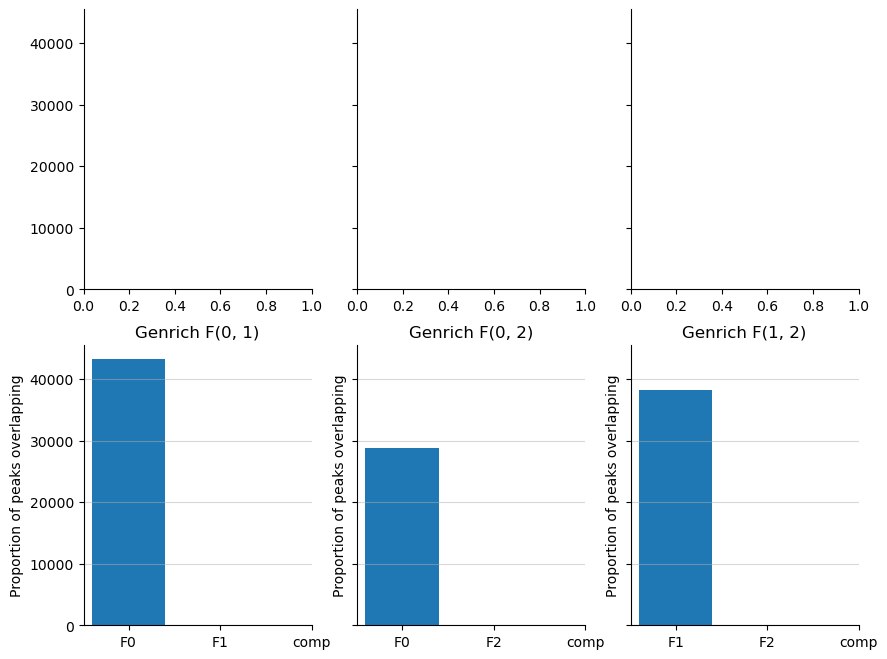

In [92]:
biorep_comb = list(itertools.combinations(range(len(bioreps)), 2))
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=False, sharey=True)
for i,comp in enumerate(macs_peaks_overlaps):
    rep = biorep_comb[i]
    print(rep[0], rep[1])
    l = [f"F{rep[0]}", f"F{rep[1]}", "comp"]
    print(l)
    axs[0][i].bar(range(len(comp)), comp)
    axs[0][i].set_title(f"MACS F{rep}")
    axs[0][i].set_ylabel("Proportion of peaks overlapping")
    axs[0][i].set_xticks(range(len(l)))
    axs[0][i].set_xticklabels(l, rotation=0)
    axs[0][i].grid(axis='y', alpha=0.5)    
for i,comp in enumerate(genrich_peaks_overlaps):
    rep = biorep_comb[i]
    print(rep[0], rep[1])
    l = [f"F{rep[0]}", f"F{rep[1]}", "comp"]
    print(l)
    axs[1][i].bar(range(len(comp)), comp)
    axs[1][i].set_title(f"Genrich F{rep}")
    axs[1][i].set_ylabel("Proportion of peaks overlapping")
    axs[1][i].set_xticks(range(len(l)))
    axs[1][i].set_xticklabels(l, rotation=0)
    axs[1][i].grid(axis='y', alpha=0.5)    
sns.despine()
 

ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of labels (3).

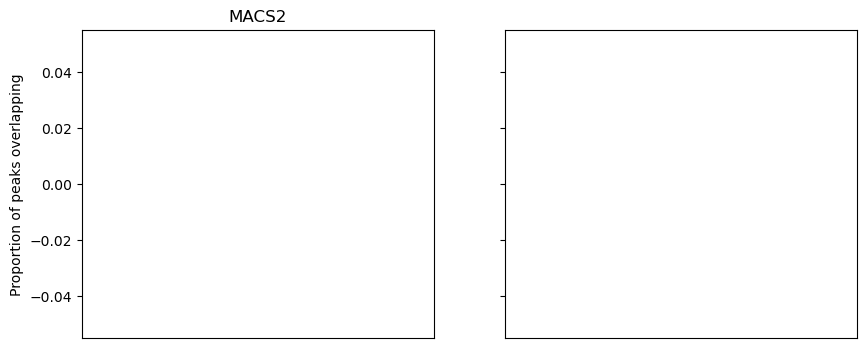

In [93]:
# make barplot of results
biorep_combinations = list(itertools.combinations(range(len(bioreps)), 2))
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
axs[0].bar(range(len(macs_peaks_overlaps)), [x[2]/x[0] for x in macs_peaks_overlaps])
axs[0].set_title("MACS2")
axs[0].set_ylabel("Proportion of peaks overlapping")
axs[0].set_xticks(range(len(macs_peaks_overlaps)))
axs[0].set_xticklabels([f"{x[0]} vs {x[1]}" for x in biorep_combinations], rotation=45)
axs[0].grid(axis='y', alpha=0.5)    

axs[1].bar(range(len(genrich_peaks_overlaps)), [x[2]/x[0] for x in genrich_peaks_overlaps])
axs[1].set_title("Genrich")
axs[1].set_xticks(range(len(genrich_peaks_overlaps)))
axs[1].set_xticklabels([f"{x[0]} vs {x[1]}" for x in biorep_combinations], rotation=45)
axs[1].grid(axis='y', alpha=0.5)    

Text(0.5, 0, 'Peak width (bp)')

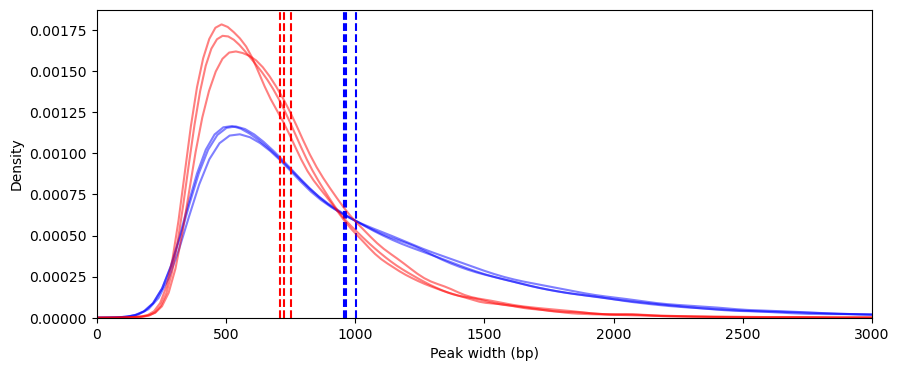

In [96]:
# note for Genrich, peaks thresholded by q value selects for wider peaks with larger q values
fig, axs = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)
for df in macs_dfs:
    sns.kdeplot(df['End']-df['Start'], color="blue", alpha=0.5)
    axs.axvline(x=np.mean(df['End']-df['Start']), color="blue", linestyle='--')
for df in genrich_dfs:
    sns.kdeplot(df['End']-df['Start'], color="red", alpha=0.5)
    axs.axvline(x=np.mean(df['End']-df['Start']), color="red", linestyle='--')
axs.set_xlim(0,3000)
axs.set_xlabel("Peak width (bp)")


In [95]:
# make new data frame that has coordinates of MACS peaks as Start and End, required by pyranges
macs_summit_df = macs_df[['Chromosome', 'peak_coord_m', 'signalValue_m']]
# make a new column that has value of peak_coord_m + 1
macs_summit_df['peak_coord_m_1'] = macs_summit_df['peak_coord_m'] + 1
macs_summit_df = macs_summit_df[['Chromosome', 'peak_coord_m', 'peak_coord_m_1', 'signalValue_m']]
macs_summit_df.columns = ['Chromosome', 'Start', 'End', 'signalValue_m']

macs_pr = pr.PyRanges(macs_summit_df)
pileup_pr = pr.PyRanges(pileup_df)


KeyError: "['peak_coord_m', 'signalValue_m'] not in index"

In [ ]:
genrich_fold_diff = np.array(pileup_pr.overlap(macs_pr).fold_diff)
macs_fold_diff = np.array(macs_pr.signalValue_m)

# print(len(genrich_fold_diff), len(macs_fold_diff))
print(np.corrcoef(genrich_fold_diff, macs_fold_diff))


[[1.         0.95918524]
 [0.95918524 1.        ]]


[[1.         0.95918524]
 [0.95918524 1.        ]]
4472
35734


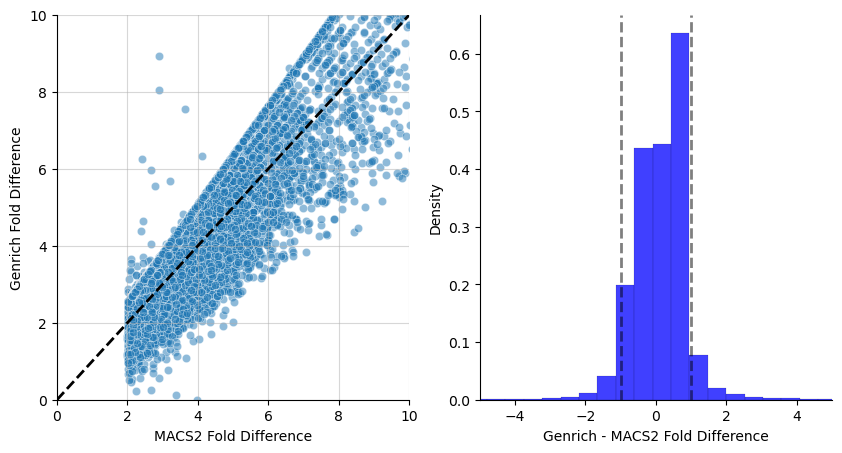

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# sns.scatterplot(x=macs_fold_diff, y=genrich_fold_diff, alpha=0.5, ax=axs[0])
sns.scatterplot(x=macs_fold_diff, y=genrich_fold_diff, alpha=0.5, ax=axs[0])
axs[0].set_xlabel("MACS2 Fold Difference", fontsize=10)
axs[0].set_ylabel("Genrich Fold Difference", fontsize=10)
axs[0].set_xlim(0,10)
axs[0].set_ylim(0,10)
# add diagonal line
axs[0].plot([0, 60], [0, 60], linewidth=2, color='black', linestyle='--')
# add grid lines
axs[0].grid(True, alpha=0.5)

sns.histplot(np.array(genrich_fold_diff)-np.array(macs_fold_diff), color="blue", bins=300, stat='density', ax=axs[1])
axs[1].set_xlim(-5,5)
axs[1].set_xlabel("Genrich - MACS2 Fold Difference", fontsize=10)
axs[1].axvline(x=1, color='black', linestyle='--', alpha=0.5, linewidth=2)
axs[1].axvline(x=-1, color='black', linestyle='--', alpha=0.5, linewidth=2)

sns.despine()   

print(np.corrcoef(genrich_fold_diff, macs_fold_diff))
print(sum(abs(genrich_fold_diff - macs_fold_diff) > 1))
print(sum(abs(genrich_fold_diff - macs_fold_diff) <= 1))

In [ ]:
m = pr.PyRanges(chromosomes=macs_df.chromosome,
                starts=macs_df.peak_coord_m - 10,
                ends=macs_df.peak_coord_m + 10)
p = pr.PyRanges(chromosomes=pileup_df.chr,
                starts=pileup_df.midpoint - 10,
                ends=pileup_df.midpoint + 10)

In [ ]:
print(len(m), len(p), len(m.overlap(p)))

1884 519936 1857
